# Linear Regression Modeling of Child Height

Outline: 
1. Load and explore the dataset: shape, datatypes, missing values in data
2. Clean and Proprocess:
   - Label encode sex
   - Create additional features:
       - interaction terms
       - polynomial terms
       - percentiles
3. Visualize data
4. Build models:
   - Create models with different features
   - Partition data into training and test subsets
   - Scale and normalize mean
   - Fit models
   - Calculate metrics: R2, RMSE, MAE
5. Compare models
6. Analyze best model:
   - check assumptions of linear regression are satisfied
   - check feature importance
   - calculate the prediction and confidence intervals
8. Make predictions with prediction and confidence intervals

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [49]:
# Load and explore data
def load_and_explore_data(file_path):
    """Load and perform initial exploration of the dataset"""
    print("Loading dataset...")
    # import dataset as a pandas DataFrame.
    df = pd.read_csv(file_path)
    
    print(f"\nDataset shape: {df.shape}")
    print(f"\nColumn info:")
    print(df.info())
    
    print(f"\nFirst few rows:")
    print(df.head())
    
    print(f"\nBasic statistics:")
    print(df.describe())
    
    print(f"\nMissing values:")
    print(df.isnull().sum())
    
    return df

In [50]:
file_path = 'galton.csv'
df = load_and_explore_data(file_path)

Loading dataset...

Dataset shape: (898, 6)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   family  898 non-null    object 
 1   father  898 non-null    float64
 2   mother  898 non-null    float64
 3   sex     898 non-null    object 
 4   height  898 non-null    float64
 5   nkids   898 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 42.2+ KB
None

First few rows:
  family  father  mother sex  height  nkids
0      1    78.5    67.0   M    73.2      4
1      1    78.5    67.0   F    69.2      4
2      1    78.5    67.0   F    69.0      4
3      1    78.5    67.0   F    69.0      4
4      2    75.5    66.5   M    73.5      4

Basic statistics:
           father      mother      height       nkids
count  898.000000  898.000000  898.000000  898.000000
mean    69.232851   64.084410   66.760690    6.135857
std      2.4

In [51]:
def clean_and_preprocess_data(df):
    """Clean and preprocess the data"""
    print("\nCleaning and preprocessing data...")
    
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    # Handle missing values (if any)
    df_clean = df_clean.dropna()
    
    # Encode sex variable
    le_sex = LabelEncoder()
    df_clean['sex_encoded'] = le_sex.fit_transform(df_clean['sex'])
    
    # Create interaction terms
    df_clean['avg_parent_height'] = (df_clean['father'] + df_clean['mother']) / 2
    df_clean['height_diff_parents'] = df_clean['father'] - df_clean['mother']
    df_clean['father_x_mother'] = df_clean['father'] * df_clean['mother']

    # Create polynomial features
    df_clean['father_sqrt'] = df_clean['father']**(0.5)
    
    # Create height percentiles within sex groups
    df_clean['height_percentile'] = df_clean.groupby('sex')['height'].rank(pct=True)
    
    print(f"Cleaned dataset shape: {df_clean.shape}")
    print(f"Sex encoding: {dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))}")
    
    return df_clean, le_sex


In [52]:
# Clean and preprocess
df_clean, label_encoder = clean_and_preprocess_data(df)


Cleaning and preprocessing data...
Cleaned dataset shape: (898, 12)
Sex encoding: {'F': 0, 'M': 1}


In [53]:
def create_visualizations(df):
    """Create comprehensive visualizations"""
    print("\nCreating visualizations...")
    
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution of heights by sex
    plt.subplot(3, 4, 1)
    sns.histplot(data=df, x='height', hue='sex', kde=True, alpha=0.7)
    plt.title('Distribution of Kids Heights by Sex')
    plt.xlabel('Height')
    plt.ylabel('Count')
    
    # 2. Scatter plot: Father vs Kid height
    plt.subplot(3, 4, 2)
    sns.scatterplot(data=df, x='father', y='height', hue='sex', alpha=0.6)
    plt.title('Father Height vs Kid Height')
    plt.xlabel('Father Height')
    plt.ylabel('Kid Height')
    
    # 3. Scatter plot: Mother vs Kid height
    plt.subplot(3, 4, 3)
    sns.scatterplot(data=df, x='mother', y='height', hue='sex', alpha=0.6)
    plt.title('Mother Height vs Kid Height')
    plt.xlabel('Mother Height')
    plt.ylabel('Kid Height')
    
    # 4. Average parent height vs kid height
    plt.subplot(3, 4, 4)
    sns.scatterplot(data=df, x='avg_parent_height', y='height', hue='sex', alpha=0.6)
    plt.title('Average Parent Height vs Kid Height')
    plt.xlabel('Average Parent Height')
    plt.ylabel('Kid Height')
    
    # 5. Correlation heatmap
    plt.subplot(3, 4, 5)
    numeric_cols = ['father', 'mother', 'height', 'nkids', 'sex_encoded', 'avg_parent_height', 'height_diff_parents', 'father_sqrt', 'father_x_mother']
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Matrix')
    
    # 6. Height Sqrt Father vs kid height
    plt.subplot(3, 4, 6)
    sns.scatterplot(data=df, x='father_sqrt', y='height', hue='sex', alpha=0.6)
    plt.title('Father Sqrt Height vs Kid Height')
    plt.xlabel('Father Sqrt Height')
    plt.ylabel('Kid Height')
    
    # 7. Height difference between parents vs kid height
    plt.subplot(3, 4, 7)
    sns.scatterplot(data=df, x='height_diff_parents', y='height', hue='sex', alpha=0.6)
    plt.title('Parent Height Difference vs Kid Height')
    plt.xlabel('Father Height - Mother Height')
    plt.ylabel('Kid Height')
    
    # 8. Distribution of average parent heights
    plt.subplot(3, 4, 8)
    sns.histplot(data=df, x='avg_parent_height', kde=True)
    plt.title('Distribution of Average Parent Heights')
    plt.xlabel('Average Parent Height')
    plt.ylabel('Count')
    
    # 9. Height by sex (violin plot)
    plt.subplot(3, 4, 9)
    sns.violinplot(data=df, x='sex', y='height')
    plt.title('Height Distribution by Sex (Violin Plot)')
    plt.xlabel('Sex')
    plt.ylabel('Height')
    
    # 10. Father x Mother vs Height
    plt.subplot(3, 4, 10)
    sns.scatterplot(data=df, x='father_x_mother', y='height', hue='sex', alpha=0.6)
    plt.title('Father x Mother Height vs Kid Height')
    plt.xlabel('Father x Mother Height')
    plt.ylabel('Kid Height')

    # 11. Height percentile by sex
    plt.subplot(3, 4, 11)
    sns.boxplot(data=df, x='sex', y='height_percentile')
    plt.title('Height Percentiles by Sex')
    plt.xlabel('Sex')
    plt.ylabel('Height Percentile')
    
    # 12. 3D-like scatter for both parents vs kid height
    plt.subplot(3, 4, 12)
    scatter = plt.scatter(df['father'], df['mother'], c=df['height'], 
                         cmap='viridis', alpha=0.6, s=30)
    plt.colorbar(scatter, label='Kid Height')
    plt.xlabel('Father Height')
    plt.ylabel('Mother Height')
    plt.title('Parent Heights vs Kid Height (Color)')
    
    plt.tight_layout()
    plt.show()


Creating visualizations...


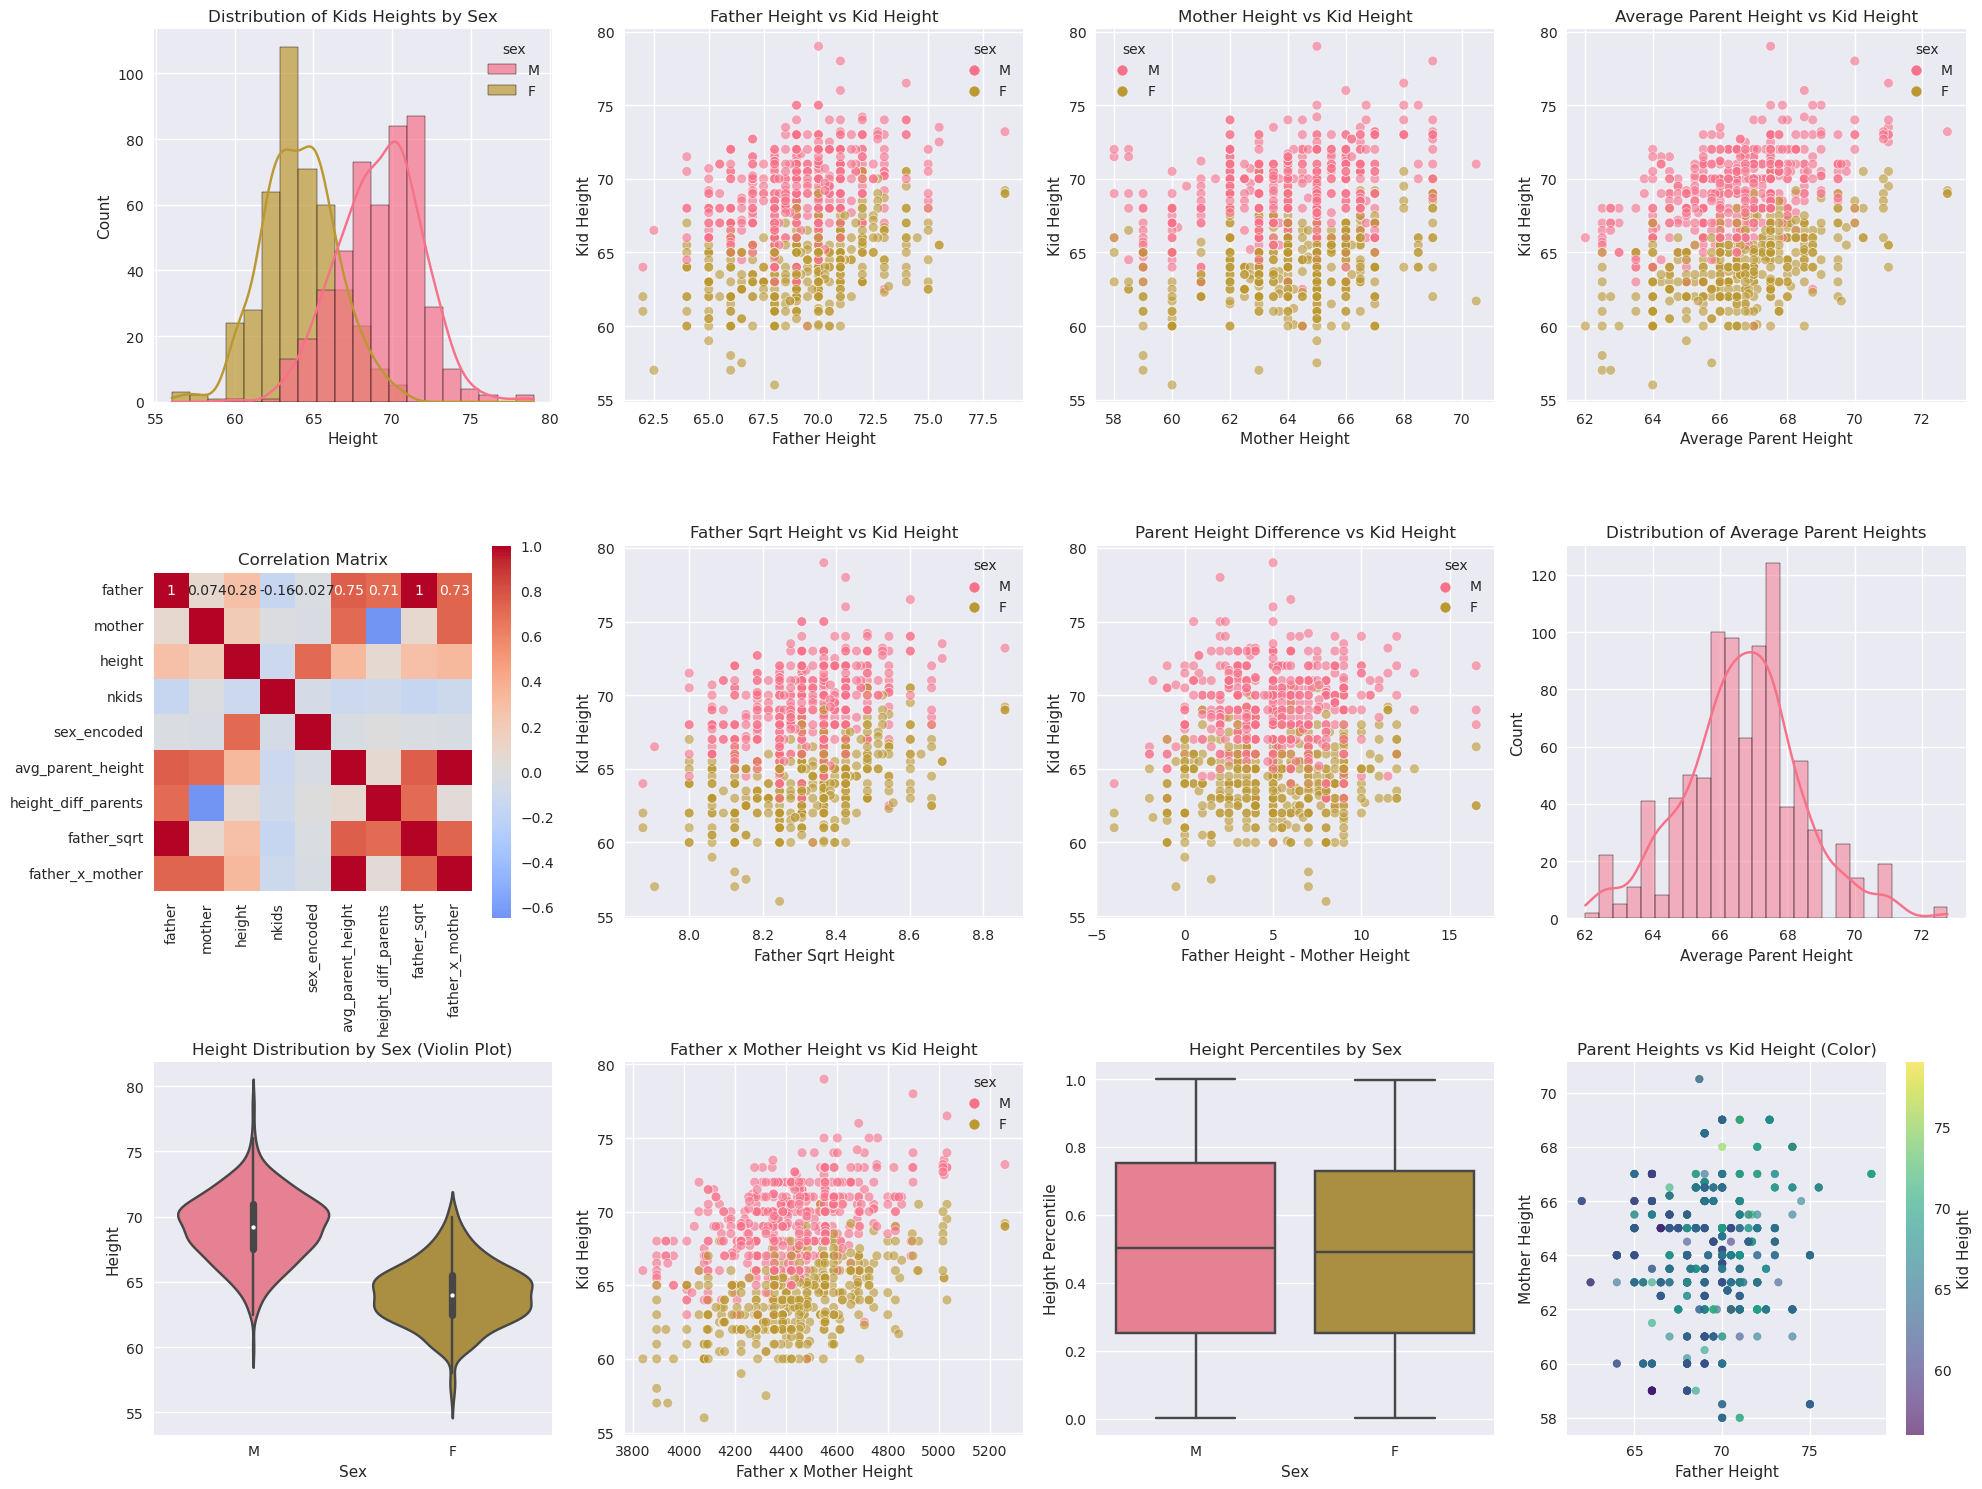

In [54]:
# Create visualizations
create_visualizations(df_clean)

In [99]:
def get_split_datasets(df, features):
    X = df[features]
    y = df['height']
    
    #Split data
    return train_test_split(X, y, test_size=0.2, random_state=42)
    
def build_models(df):
    """Build and evaluate multiple regression models"""
    print("\nBuilding regression models...")
    
    # Define feature sets
    feature_sets = {
        'Basic': ['father', 'mother', 'sex_encoded'],
        'Extended': ['father', 'mother', 'sex_encoded'],  
        'Interaction': ['father_x_mother', 'sex_encoded'],
        'Polynomial': ['father_sqrt', 'mother', 'sex_encoded'],
        'Engineered': ['father', 'mother', 'sex_encoded', 'avg_parent_height', 'height_diff_parents'],
        'All Features': ['father', 'mother', 'sex_encoded', 'nkids', 'avg_parent_height', 'height_diff_parents']
    }
    
    results = {}
    models = {}
 
    for name, features in feature_sets.items():
        print(f"\nTraining model: {name}")
        
        # Prepare data        
        X_train, X_test, y_train, y_test = get_split_datasets(df, features)
        
        # Create pipeline with scaling and regression
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        
        # Fit model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)
   
        results[name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'features': features,
            'y_pred_test': y_pred_test,
            'y_test': y_test,
        }
        
        models[name] = pipeline
        
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Test R²: {test_r2:.4f}")
        print(f"  Test RMSE: {test_rmse:.4f}")
        print(f"  Test MAE: {test_mae:.4f}")
    
    return results, models

In [59]:
# Build models
results, models = build_models(df_clean)


Building regression models...

Training model: Basic
  Train R²: 0.6450
  Test R²: 0.6112
  Test RMSE: 2.1608
  Test MAE: 1.6373

Training model: Extended
  Train R²: 0.6450
  Test R²: 0.6112
  Test RMSE: 2.1608
  Test MAE: 1.6373

Training model: Interaction
  Train R²: 0.6402
  Test R²: 0.6213
  Test RMSE: 2.1323
  Test MAE: 1.6093

Training model: Polynomial
  Train R²: 0.6450
  Test R²: 0.6107
  Test RMSE: 2.1620
  Test MAE: 1.6381

Training model: Engineered
  Train R²: 0.6444
  Test R²: 0.6085
  Test RMSE: 2.1680
  Test MAE: 1.6490

Training model: All Features
  Train R²: 0.6457
  Test R²: 0.6100
  Test RMSE: 2.1639
  Test MAE: 1.6383


In [80]:
def compare_models(results):
    """Compare all models performance"""
    print("\nModel comparison summary:")
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test R²': [results[name]['test_r2'] for name in results.keys()],
        'Test RMSE': [results[name]['test_rmse'] for name in results.keys()],
        'Test MAE': [results[name]['test_mae'] for name in results.keys()],
        'Overfitting': [results[name]['train_r2'] - results[name]['test_r2'] for name in results.keys()]
    })
    
    print(comparison_df.round(4))
    
    # Plot model comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    margin = 0.05
    # R² comparison
    metrics = [ 'Test R²', 'Test RMSE', 'Overfitting' ]
    titles = [ 'Test R² Comparison', 'Test RMSE Comparison', 'Overfitting Comparison (Train R² - Test R²)']
    ylabels = [ 'R² Score', 'RMSE', 'Overfitting Score']
    plot = 0
    for i, metric in enumerate(metrics):
        min_val = min(comparison_df[metric])
        max_val = max(comparison_df[metric])
        plot_margin = (max_val - min_val)*0.1
        axes[i].bar(comparison_df['Model'], comparison_df[metric])
        axes[i].set_title(titles[i])
        axes[i].set_ylabel(ylabels[i])
        axes[i].set_ylim(min_val*(1-plot_margin), max_val*(1+plot_margin))
        axes[i].tick_params(axis='x', rotation=45)
        
    plt.tight_layout()
    plt.show()


Model comparison summary:
          Model  Test R²  Test RMSE  Test MAE  Overfitting
0         Basic   0.6112     2.1608    1.6373       0.0339
1      Extended   0.6112     2.1608    1.6373       0.0339
2   Interaction   0.6213     2.1323    1.6093       0.0189
3    Polynomial   0.6107     2.1620    1.6381       0.0342
4    Engineered   0.6085     2.1680    1.6490       0.0358
5  All Features   0.6100     2.1639    1.6383       0.0357


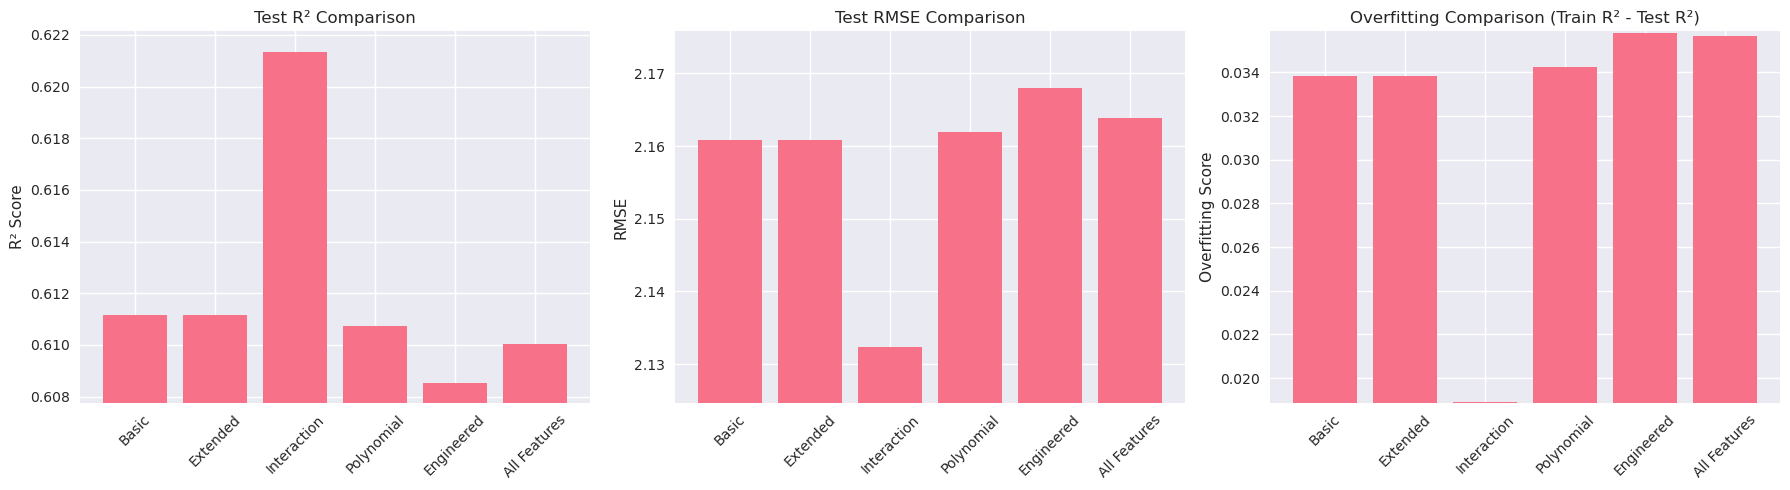

In [81]:
# Compare models
compare_models(results)

In [62]:

def analyze_best_model(results, models, df):
    """Analyze the best performing model in detail"""
    print("\nDetailed analysis of best model...")
    
    # Find best model based on test R²
    best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
    best_model = models[best_model_name]
    best_results = results[best_model_name]

    print(f"Best model: {best_model_name}")
    print(f"Test R²: {best_results['test_r2']:.4f}")
    print(f"Test RMSE: {best_results['test_rmse']:.4f}")
    print(f"Test MAE: {best_results['test_mae']:.4f}")
    
    # Get feature importance (coefficients)
    feature_names = best_results['features']
    coefficients = best_model.named_steps['regressor'].coef_
    intercept = best_model.named_steps['regressor'].intercept_
    
    print(f"\nModel coefficients:")
    print(f"Intercept: {intercept:.4f}")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")
    
    # Create detailed plots for best model
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Actual vs Predicted - Checks Linearity Assumption
    axes[0, 0].scatter(best_results['y_test'], best_results['y_pred_test'], alpha=0.6)
    axes[0, 0].plot([best_results['y_test'].min(), best_results['y_test'].max()], 
                    [best_results['y_test'].min(), best_results['y_test'].max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Height')
    axes[0, 0].set_ylabel('Predicted Height')
    axes[0, 0].set_title(f'Linearity Check: Actual vs Predicted Heights ({best_model_name})')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals plot - Checks Homoscedasticity and Linearity Assumptions
    residuals = best_results['y_test'] - best_results['y_pred_test']
    axes[0, 1].scatter(best_results['y_pred_test'], residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Height')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Homoscedasticity Check: Residuals Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values('abs_coefficient', ascending=True)
    
    axes[1, 0].barh(range(len(feature_importance)), feature_importance['coefficient'])
    axes[1, 0].set_yticks(range(len(feature_importance)))
    axes[1, 0].set_yticklabels(feature_importance['feature'])
    axes[1, 0].set_xlabel('Coefficient Value')
    axes[1, 0].set_title('Feature Importance (Coefficients)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Residuals histogram - Checks Normality of residuals
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Normality Check: Distribution of Residuals')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return best_model_name, best_model


Detailed analysis of best model...
Best model: Interaction
Test R²: 0.6213
Test RMSE: 2.1323
Test MAE: 1.6093

Model coefficients:
Intercept: 66.8252
father_x_mother: 1.2514
sex_encoded: 2.6328


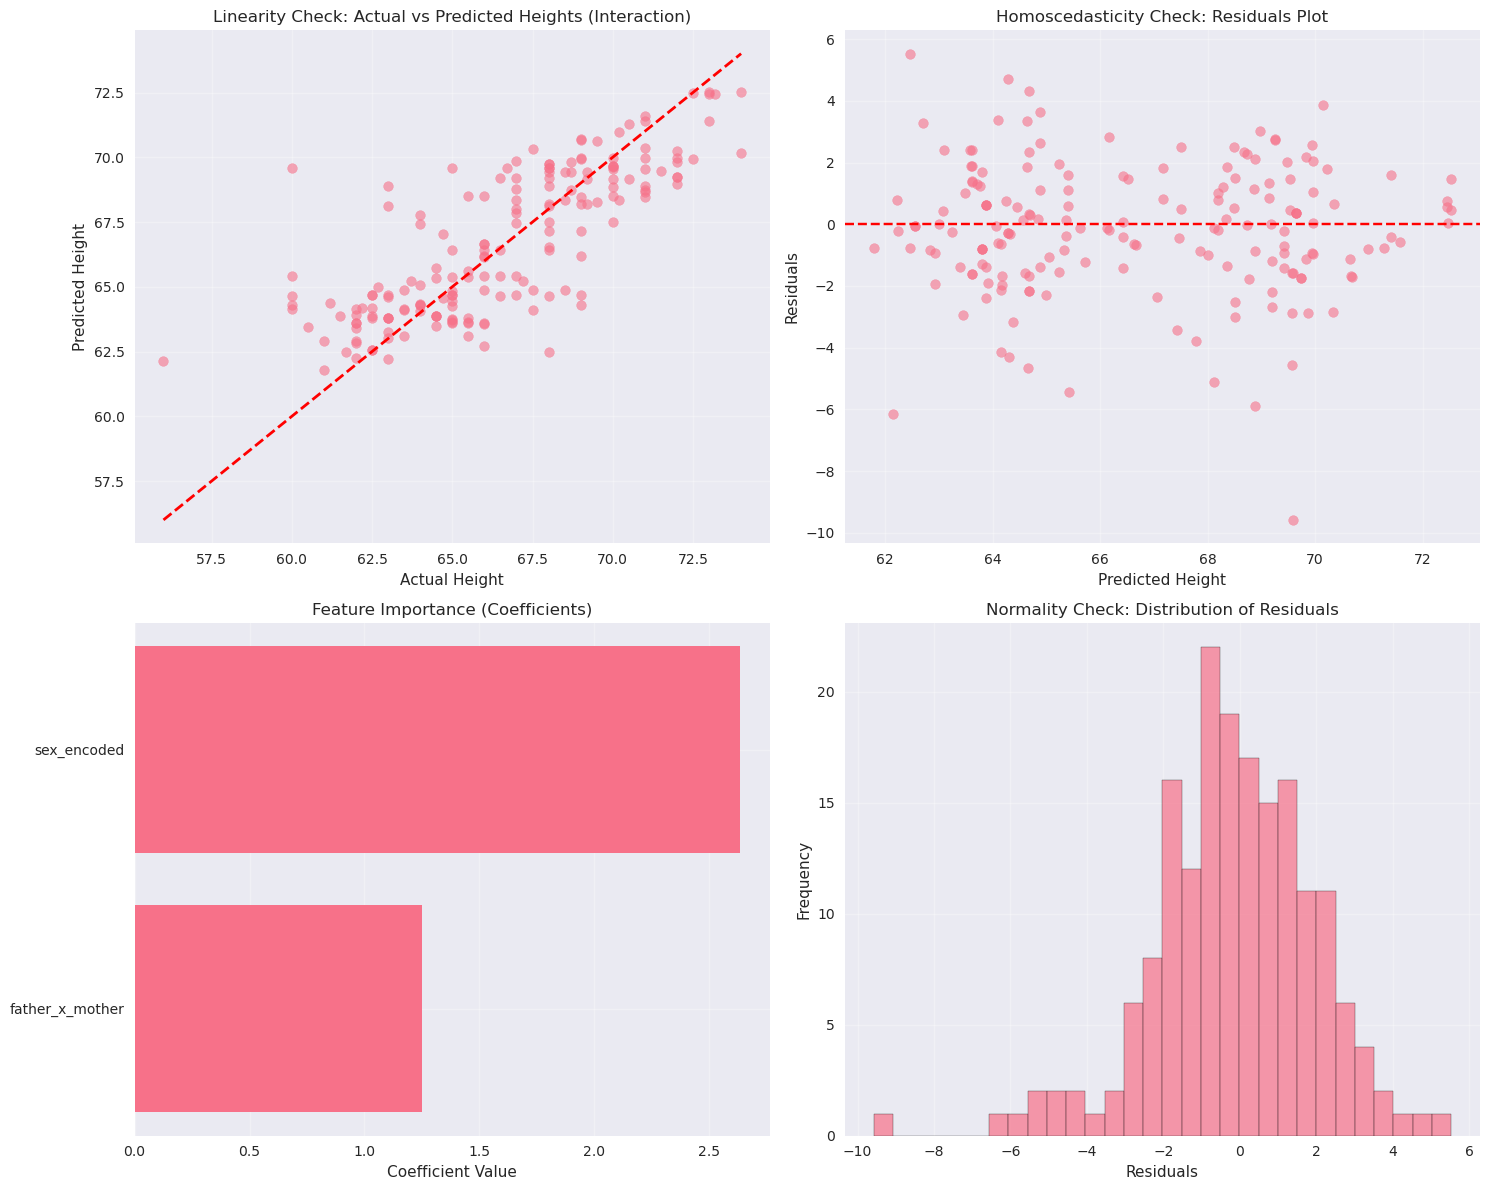

In [63]:
# Analyze best model
best_model_name, best_model = analyze_best_model(results, models, df_clean)

In [96]:
def calculate_intervals(model, X_train, y_train, X_new, confidence_level=-0.95):
    """
    Calculate confidence and prediction intervals for linear regression

    Parameters: 
    - model: fitted sklearn Pipeline with StandardScalar and LinearRegression
    - X_train: training features (original scale, before scaling)
    - y_train: training target
    - X_new: new data points for prediction (original scale)
    - confidence_level: confidence level (default 0.95)

    Returns:
    - predictions: point predictions
    - conf_lower, conf_upper: confidence interval bounds
    - pred_lower, pred_upper: prediction interval bounds
    """

    #Get the regression model from the pipeline
    regressor = model.named_steps['regressor']
    scaler = model.named_steps['scaler']

    #Scale the data
    X_train_scaled = scaler.transform(X_train)
    X_new_scaled = scaler.transform(X_new)

    #Get predictions
    predictions = model.predict(X_new)

    #Calculate residuals and MSE from training data
    y_train_pred = model.predict(X_train)
    residuals = y_train - y_train_pred
    mse = np.mean(residuals**2)

    #Degrees of freedom
    n = len(X_train)
    dof = n - X_train_scaled.shape[1] - 1

    #t-statistic for given confidence level
    alpha = 1 - confidence_level
    t_stat = stats.t.ppf(1 - alpha/2, dof)

    #Create design matrices (and intercept column)
    X_train_design = np.column_stack([np.ones(n), X_train_scaled])
    X_new_design = np.column_stack([np.ones(len(X_new_scaled)), X_new_scaled])

    #Calculate standard errors
    try:
        #Covariance matrix of parameters
        XTX_inv = np.linalg.inv(X_train_design.T @ X_train_design)

        conf_intervals = []
        pred_intervals = []

        for i in range(len(X_new_design)):
            x_new = X_new_design[i:i+1] #keep as 2D array

            #Standard error for confidence interval (mean response)
            se_conf = np.sqrt(mse * (x_new @ XTX_inv @ x_new.T)[0, 0])

            #Standard error for prediction interval (individual response)
            se_pred = np.sqrt(mse * (1 + (x_new @ XTX_inv @ x_new.T)[0, 0]))

            #Calculate intervals
            margin_conf = t_stat * se_conf
            margin_pred = t_stat * se_pred

            conf_intervals.append([predictions[i] - margin_conf, predictions[i] + margin_conf])
            pred_intervals.append([predictions[i] - margin_pred, predictions[i] + margin_pred])

        conf_intervals = np.array(conf_intervals)
        pred_intervals = np.array(pred_intervals)

        return (predictions,
                conf_intervals[:, 0], conf_intervals[:, 1], #conf_lower, conf_upper
                pred_intervals[:, 0], pred_intervals[:, 1]) #pred_lower, pred_upper

    except np.linalg.LinAlgError:
        print("Warning: Could not calculate intervals due to singluar matrix")
        #Return NaN intervals if calculation fails
        return (predictions, 
                np.full_like(predictions, np.nan), np.full_like(predictions, np.nan),
                np.full_like(predictions, np.nan), np.full_like(predictions, np.nan))


In [97]:
def make_predictions_with_intervals(model, df, model_features, X_train, y_train, sample_data=None, confidence_level=0.95):
    """Make predictions with confidence and prediction intervals"""
    print(f"\nMaking sample predictions with {confidence_level*100:.0f}% intervals...")
    
    if sample_data is None:
        # Create sample data from the dataset
        # features = ['father', 'mother', 'sex_encoded', 'nkids', 'avg_parent_height', 'height_diff_parents', 'father_sqrt', 'father_x_mother']
        sample_data = df.sample(5)
    sample_data = sample_data[model_features]

    #Get predictions and intervals
    predictions, conf_lower, conf_upper, pred_lower, pred_upper = calculate_intervals(
        model, X_train, y_train, sample_data, confidence_level
    )

    print(f"Using features: {model_features}")
    print(f"\nPrediction Results:")
    print("=" * 80)
    
    print(f"\nFirst few rows:")
    print(sample_data.head())

    for i in range(len(predictions)):
        pred = predictions[i]

        #Get feature values for this prediction
        feature_values = sample_data.iloc[i]
        feature_str = ", ".join([f"{feat}={val:.1f}" for feat, val in zip(model_features, feature_values)])

        print(f"\nSample {i+1}:")
        print(f"  Input features: {feature_str}")
        print(f"  Point prediction: {pred:.2f} inches")
        print(f"  {confidence_level*100:.0f}% Confidence interval: [{conf_lower[i]:.2f}, {conf_upper[i]:.2f}] inches")
        print(f"  {confidence_level*100:.0f}% Prediction interval: [{pred_lower[i]:.2f}, {pred_upper[i]:.2f}] inches")
        print(f"  Confidence interval width: {conf_upper[i] - conf_lower[i]:.2f} inches")
        print(f"  Prediction interval width: {pred_upper[i] - pred_lower[i]:.2f} inches")

    #Create visualization of predictions with intervals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    #Plot 1: Predictions with intervals
    x_pos = range(len(predictions))
    ax1.scatter(x_pos, predictions, color='red', s=100, zorder=5, label='Point Prediction')

    #Plot confidence intervals
    for i, x in enumerate(x_pos):
        ax1.plot([x, x], [conf_lower[i], conf_upper[i]], 'b-', linewidth=3, alpha=0.7, label='Confidence Interval' if i == 0 else "")

    #Plot prediction intervals
    for i, x in enumerate(x_pos):
        ax1.plot([x, x], [pred_lower[i], pred_upper[i]], 'g-', linewidth=2, alpha=0.7, label='Prediction Interval' if i == 0 else "")

    ax1.set_xlabel('Sample Number')
    ax1.set_ylabel('Height (inches)')
    ax1.set_title('Predictions with Confidence and Prediction Intervals')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'Sample {i+1}' for i in x_pos])
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Interval widths comparison
    conf_widths = conf_upper - conf_lower
    pred_widths = pred_upper - pred_lower
    
    x_offset = np.arange(len(predictions))
    width = 0.35
    
    ax2.bar(x_offset - width/2, conf_widths, width, label='Confidence Interval Width', alpha=0.7)
    ax2.bar(x_offset + width/2, pred_widths, width, label='Prediction Interval Width', alpha=0.7)
    
    ax2.set_xlabel('Sample Number')
    ax2.set_ylabel('Interval Width (inches)')
    ax2.set_title('Interval Widths Comparison')
    ax2.set_xticks(x_offset)
    ax2.set_xticklabels([f'Sample {i+1}' for i in range(len(predictions))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return results for further analysis if needed
    return {
        'predictions': predictions,
        'conf_lower': conf_lower,
        'conf_upper': conf_upper,
        'pred_lower': pred_lower,
        'pred_upper': pred_upper,
        'sample_data': sample_data
    }


Making sample predictions with 95% intervals...
shape of conf_intervals[:, 0] (5,) shape of conf_lower[0] () <class 'numpy.float64'> <class 'float'>
shape of pred_intervals[:, 0] (5,) shape of pred_lower[0] () <class 'numpy.float64'> <class 'float'>
Using features: ['father_x_mother', 'sex_encoded']

Prediction Results:

First few rows:
     father_x_mother  sex_encoded
325           4512.0            1
823           4355.0            1
305           4529.0            0
765           4356.0            0
657           4259.4            1
69.51280779122062

Sample 1:
  Input features: father_x_mother=4512.0, sex_encoded=1.0
  Point prediction: 69.74 inches
  95% Confidence interval: [69.51, 69.96] inches
  95% Prediction interval: [65.49, 73.99] inches
  Confidence interval width: 0.45 inches
  Prediction interval width: 8.51 inches

Sample 2:
  Input features: father_x_mother=4355.0, sex_encoded=1.0
  Point prediction: 68.90 inches
  95% Confidence interval: [68.67, 69.12] inches
  95%

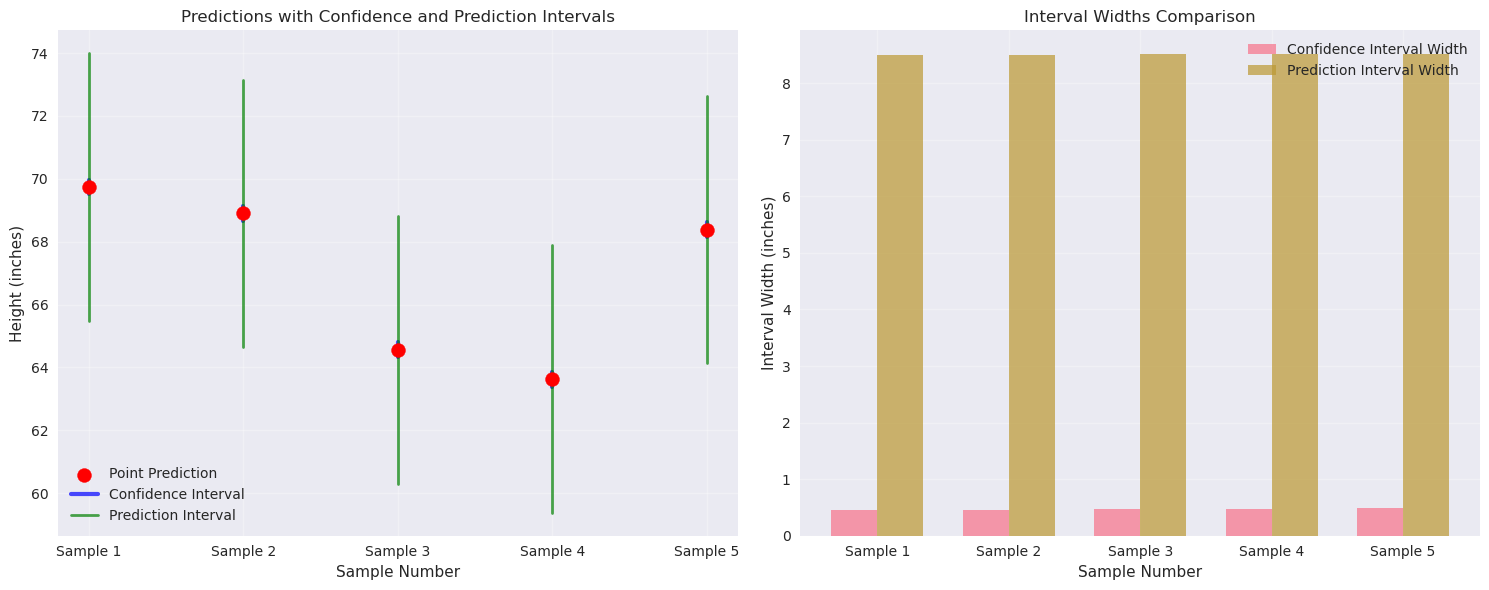


Analysis complete! Best model: Interaction


In [95]:
# Make sample predictions using the best model's features
best_model_features = results[best_model_name]['features']

#Get training data for interval calculations
X_train, X_test, y_train, y_test = get_split_datasets(df_clean, best_model_features)

prediction_results = make_predictions_with_intervals(
    best_model, df_clean, best_model_features, X_train, y_train
)

print(f"\nAnalysis complete! Best model: {best_model_name}")


Cleaning and preprocessing data...
Cleaned dataset shape: (2, 12)
Sex encoding: {'F': 0, 'M': 1}

Making sample predictions with 98% intervals...
Using features: ['father_x_mother', 'sex_encoded']

Prediction Results:

First few rows:
   father_x_mother  sex_encoded
0             3500            1
1             3500            0

Sample 1:
  Input features: father_x_mother=3500.0, sex_encoded=1.0
  Point prediction: 64.31 inches
  98% Confidence interval: [63.52, 65.10] inches
  98% Prediction interval: [59.20, 69.41] inches
  Confidence interval width: 1.59 inches
  Prediction interval width: 10.21 inches

Sample 2:
  Input features: father_x_mother=3500.0, sex_encoded=0.0
  Point prediction: 59.04 inches
  98% Confidence interval: [58.23, 59.84] inches
  98% Prediction interval: [53.93, 64.14] inches
  Confidence interval width: 1.61 inches
  Prediction interval width: 10.22 inches


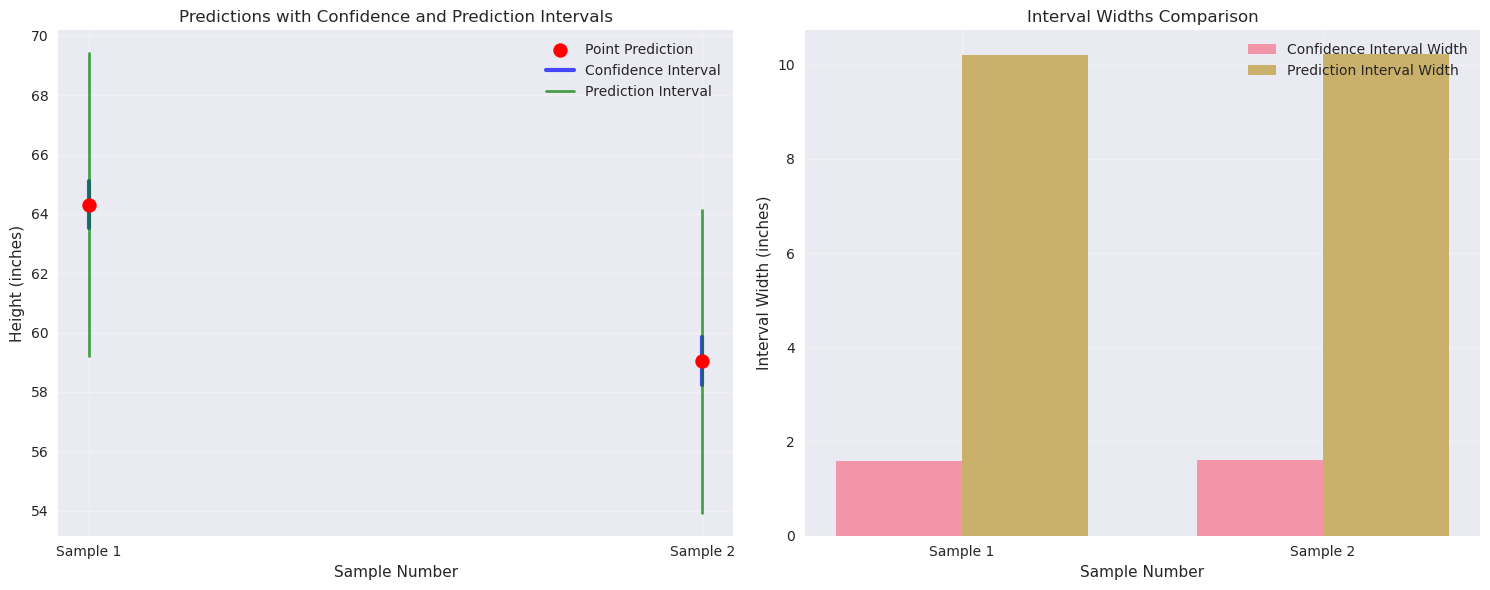


Analysis complete! Best model: Interaction


In [101]:
# predict the height of a child whose father is 50 inches and whose mother is 70 inches tall.
max_family_num = max(df['family'])

example_data = pd.DataFrame([
    {'family': int(max_family_num)+1, 'father': 70, 'mother': 50, 'nkids': 2, 'sex': 'M', 'height': 0},
    {'family': int(max_family_num)+1, 'father': 70, 'mother': 50, 'nkids': 2, 'sex': 'F', 'height': 0},
                           ])
example_df_clean, _ignore = clean_and_preprocess_data(example_data)

#Get training data for interval calculations
X_train, X_test, y_train, y_test = get_split_datasets(df_clean, best_model_features)

example_prediction_results = make_predictions_with_intervals(
    best_model, df_clean, best_model_features, X_train, y_train, sample_data=example_df_clean, confidence_level=0.98
)

print(f"\nAnalysis complete! Best model: {best_model_name}")